In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
import beam.calc.electron as ecalc
from lens import profile
from scipy.optimize import minimize
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
from matplotlib.ticker import FormatStrFormatter

grey = '#444444'

alpha_m= -0.1


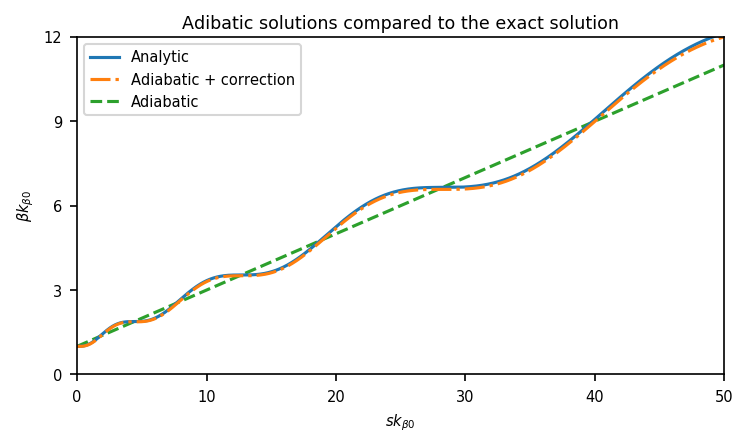

In [2]:
# Higher order adiabatic solution
N = 10000
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(0, 100, N, retstep=True)
betam = 1+a*z
frac = 1/(1+a*z)**2
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Exact solution
c1 = 0.5*(beta0 - (gamma0-2*alpha0*alpham+alpham**2*beta0)/(1-alpham**2))
c2 = (alpha0-alpham*beta0)/np.sqrt(1-alpham**2)
c0 = np.sqrt(c1**2+c2**2+1/(1-alpham**2))
Phi = np.sqrt(1-alpham**2)*np.log(betam)/(2*alpham)
beta_exact = betam*(c0+c1*np.cos(2*Phi)+c2*np.sin(2*Phi))

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Higher order adibatic solution
c0 = 0.5*(beta0+gamma0-2*alpha0*alpham)
c1 = 0.5*(beta0-gamma0+2*alpha0*alpham)
c2 = -alpha0+alpham*beta0
theta = np.cumsum(1/betam)*dz
beta_adi2 = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

fig = plt.figure(figsize=(5, 3), dpi=150)
ax = plt.subplot(111)
#plt.plot(z, beta)
plt.plot(z, beta_exact)
plt.plot(z, beta_adi2, '-.')
plt.plot(z, beta_adi, '--', zorder=1)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.title('Adibatic solutions compared to the exact solution')
plt.legend([r'Analytic', r'Adiabatic + correction', r'Adiabatic'])
ax.yaxis.set_ticks(np.linspace(0, 12, 5))
plt.ylim(0, 12)
plt.xlim(0, 50)
plt.tight_layout()
plt.show()

1.00005217288


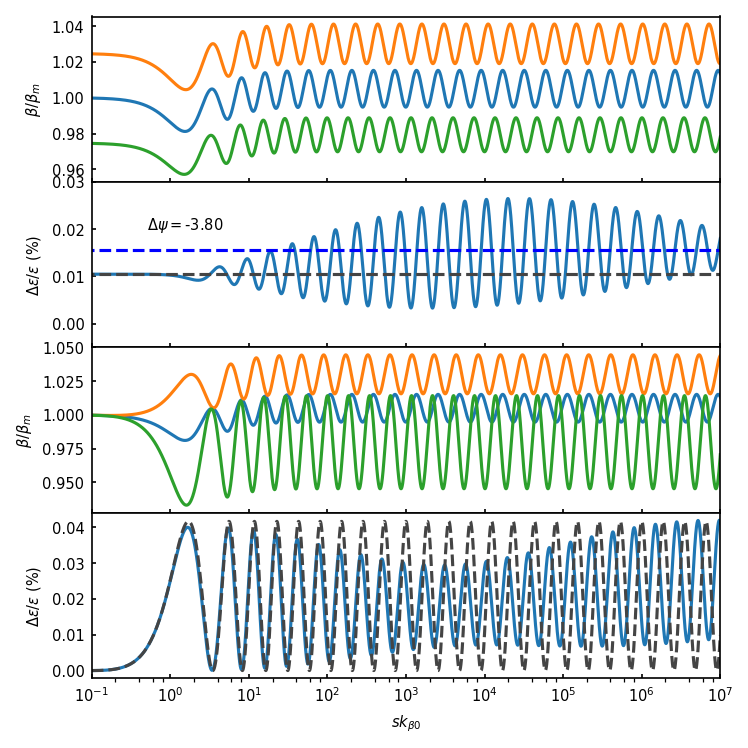

In [3]:
# Emittance growth for large delta, large alpham
N = 100000
beta0 = 1.0
alpha0 = 0
gb0 = 20000
delta = 0.05
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
alpham = -a/2
z = np.logspace(-1, 7, N)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*np.sqrt(1+deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(0.5*(1/betam[1:-1]+1/betam[:-2])*(z[1:-1]-z[:-2]))
deltaPsi = theta*(1/np.sqrt(1+delta)-1/np.sqrt(1-delta))

# Saturated emittance and dephasing
deltabeta = np.amax((beta/betam)[int(N/2):]) - np.amin((beta/betam)[int(N/2):])
epssat = 0.5*(1+deltabeta/2+1/(1+deltabeta/2))
print(epssat)
    
# Plotting
fig = plt.figure(figsize=(5, 5), dpi=150)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot([0, z[-1]], [delta**2/24*100, delta**2/24*100], '--', c=grey)
ax2.plot([0, z[-1]], [(epssat-1+delta**2/24)*100, (epssat-1+delta**2/24)*100], 'b--')
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
plt.ylim(-0.005, 0.03)
plt.text(0.5, 0.02, r'$\Delta\psi=$'+'%0.2f' % deltaPsi[-1])
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))

# Plot 2 beams all start with the same initial conditions
#-----------------------------------------------------------------------------------------
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1-delta), dgdz0, ne0)

for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)

# Plotting
ax3 = plt.subplot(gs[2, 0], sharex=ax1)
ax3.plot(z, beta/betam)
ax3.plot(z, beta1/betam)
ax3.plot(z, betan1/betam)
plt.ylabel(r'$\beta/\beta_m$')
ax3.tick_params(top=False,bottom=True,left=True,direction='in',length=2)

ax4 = plt.subplot(gs[3, 0], sharex=ax1)
ax4.plot(z, (eps-1)*100)
ax4.plot(z[:-2], (1-np.cos(2*theta))*delta**2/12*100, '--', c=grey)
#plt.ylim(0, 1.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax4.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
plt.xlim(z[0], z[-1])
plt.xlabel(r'$s k_{\beta0}$')
ax1.set_xscale('log')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

1.00000000031


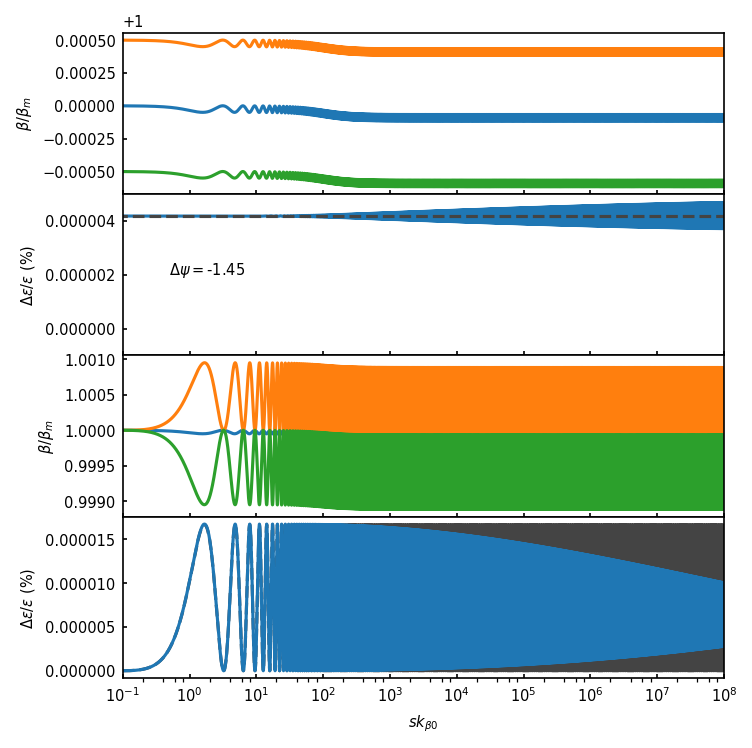

In [4]:
# Emittance growth for small delta, small alpham
N = 100000
beta0 = 1.0
alpha0 = 0
gb0 = 20000
delta = 0.001
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.01
alpham = -a/2
z = np.logspace(-1, 8, N)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*np.sqrt(1+deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(0.5*(1/betam[1:-1]+1/betam[:-2])*(z[1:-1]-z[:-2]))
deltaPsi = theta*(1/np.sqrt(1+delta)-1/np.sqrt(1-delta))

# Saturated emittance and dephasing
deltabeta = np.amax((beta/betam)[int(N/2):]) - np.amin((beta/betam)[int(N/2):])
epssat = 0.5*(1+deltabeta/2+1/(1+deltabeta/2))
print(epssat)
    
# Plotting
fig = plt.figure(figsize=(5, 5), dpi=150)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot([0, z[-1]], [delta**2/24*100, delta**2/24*100], '--', c=grey)
#ax2.plot([0, z[-1]], [(epssat-1+delta**2/24)*100, (epssat-1+delta**2/24)*100], 'b--')
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
plt.ylim(-1e-6, 5e-6)
plt.text(0.5, 2e-6, r'$\Delta\psi=$'+'%0.2f' % deltaPsi[-1])
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))

# Plot 2 beams all start with the same initial conditions
#-----------------------------------------------------------------------------------------
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1-delta), dgdz0, ne0)

for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)

# Plotting
ax3 = plt.subplot(gs[2, 0], sharex=ax1)
ax3.plot(z, beta/betam)
ax3.plot(z, beta1/betam)
ax3.plot(z, betan1/betam)
plt.ylabel(r'$\beta/\beta_m$')
ax3.tick_params(top=False,bottom=True,left=True,direction='in',length=2)

ax4 = plt.subplot(gs[3, 0], sharex=ax1)
ax4.plot(z, (eps-1)*100)
ax4.plot(z[:-2], (1-np.cos(2*theta))*delta**2/12*100, '--', c=grey, zorder=1)
#plt.ylim(0, 1.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax4.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
plt.xlim(z[0], z[-1])
plt.xlabel(r'$s k_{\beta0}$')
ax1.set_xscale('log')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

1.00000000034


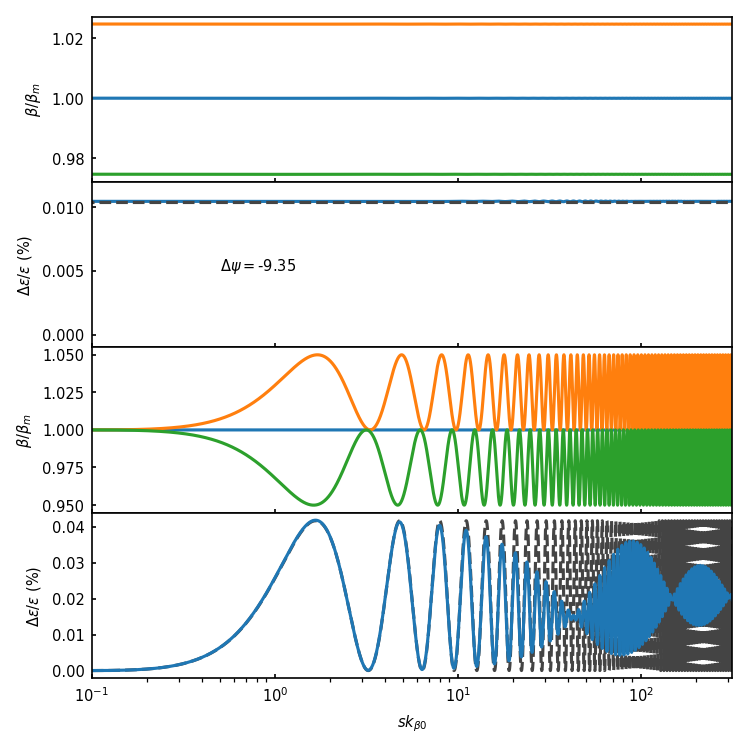

In [5]:
# Emittance growth for large delta, small alpham
N = 100000
beta0 = 1.0
alpha0 = 0
gb0 = 20000
delta = 0.05
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.01
alpham = -a/2
z = np.logspace(-1, 2.5, N)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*np.sqrt(1+deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(0.5*(1/betam[1:-1]+1/betam[:-2])*(z[1:-1]-z[:-2]))
deltaPsi = theta*(1/np.sqrt(1+delta)-1/np.sqrt(1-delta))

# Saturated emittance and dephasing
deltabeta = np.amax((beta/betam)[int(N/2):]) - np.amin((beta/betam)[int(N/2):])
epssat = 0.5*(1+deltabeta/2+1/(1+deltabeta/2))
print(epssat)

# Plotting
fig = plt.figure(figsize=(5, 5), dpi=150)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot([0, z[-1]], [delta**2/24*100, delta**2/24*100], '--', c=grey)
#ax2.plot([0, z[-1]], [(epssat-1+delta**2/24)*100, (epssat-1+delta**2/24)*100], 'b--')
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
plt.ylim(-1e-3, .012)
plt.text(0.5, .005, r'$\Delta\psi=$'+'%0.2f' % deltaPsi[-1])
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))

# Plot 2 beams all start with the same initial conditions
#-----------------------------------------------------------------------------------------
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1-delta), dgdz0, ne0)

for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)

# Plotting
ax3 = plt.subplot(gs[2, 0], sharex=ax1)
ax3.plot(z, beta/betam)
ax3.plot(z, beta1/betam)
ax3.plot(z, betan1/betam)
plt.ylabel(r'$\beta/\beta_m$')
ax3.tick_params(top=False,bottom=True,left=True,direction='in',length=2)

ax4 = plt.subplot(gs[3, 0], sharex=ax1)
ax4.plot(z, (eps-1)*100)
ax4.plot(z[:-2], (1-np.cos(2*theta))*delta**2/12*100, '--', c=grey, zorder=1)
#plt.ylim(0, 1.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax4.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
plt.xlim(z[0], z[-1])
plt.xlabel(r'$s k_{\beta0}$')
ax1.set_xscale('log')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

1.00005217288


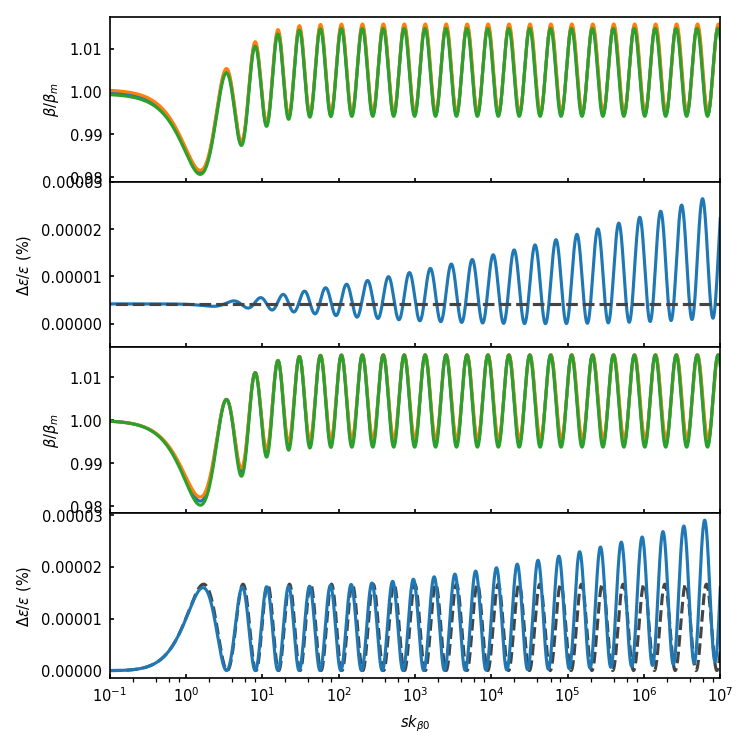

In [6]:
# Emittance growth for small delta, large alpham
N = 100000
beta0 = 1.0
alpha0 = 0
gb0 = 20000
delta = 0.001
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
alpham = -a/2
z = np.logspace(-1, 7, N)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*np.sqrt(1+deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(0.5*(1/betam[1:-1]+1/betam[:-2])*(z[1:-1]-z[:-2]))
deltaPsi = theta*(1/np.sqrt(1+delta)-1/np.sqrt(1-delta))

# Saturated emittance and dephasing
deltabeta = np.amax((beta/betam)[int(N/2):]) - np.amin((beta/betam)[int(N/2):])
epssat = 0.5*(1+deltabeta/2+1/(1+deltabeta/2))
print(epssat)

# Plotting
fig = plt.figure(figsize=(5, 5), dpi=150)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot([0, z[-1]], [delta**2/24*100, delta**2/24*100], '--', c=grey)
ax2.plot([0, z[-1]], [(epssat-1+delta**2/24)*100, (epssat-1+delta**2/24)*100], 'b--')
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
plt.ylim(-0.5e-5, 3e-5)
#plt.text(0.5, .01042, r'$\Delta\psi=$'+'%0.2f' % deltaPsi[-1])
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))

# Plot 2 beams all start with the same initial conditions
#-----------------------------------------------------------------------------------------
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1-delta), dgdz0, ne0)

for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)

# Plotting
ax3 = plt.subplot(gs[2, 0], sharex=ax1)
ax3.plot(z, beta/betam)
ax3.plot(z, beta1/betam)
ax3.plot(z, betan1/betam)
plt.ylabel(r'$\beta/\beta_m$')
ax3.tick_params(top=False,bottom=True,left=True,direction='in',length=2)

ax4 = plt.subplot(gs[3, 0], sharex=ax1)
ax4.plot(z, (eps-1)*100)
ax4.plot(z[:-2], (1-np.cos(2*theta))*delta**2/12*100, '--', c=grey, zorder=1)
#plt.ylim(0, 1.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax4.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
plt.xlim(z[0], z[-1])
plt.xlabel(r'$s k_{\beta0}$')
ax1.set_xscale('log')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

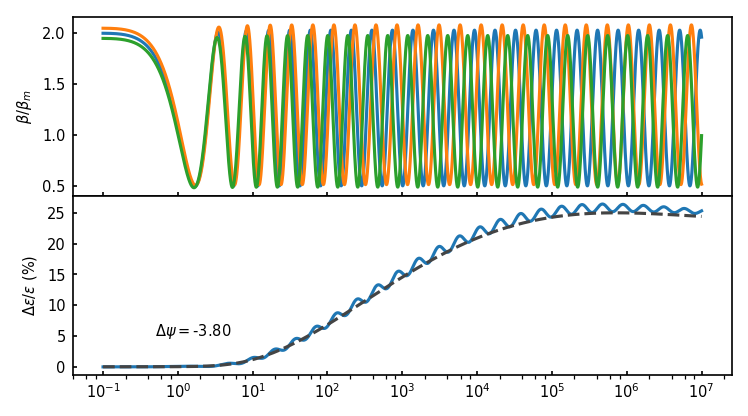

In [7]:
# Emittance growth when mismatched to an adiabatic ramp
N = 100000
beta0 = 2.0
alpha0 = 0
gb0 = 20000
delta = 0.05
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
alpham = -a/2
z = np.logspace(-1, 7, N)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(0.5*(1/betam[1:-1]+1/betam[:-2])*(z[1:-1]-z[:-2]))
deltaPsi = theta*(1/np.sqrt(1+delta)-1/np.sqrt(1-delta))

# Saturated emittance and dephasing
epssat = 0.5*(beta0+1/beta0)
fac = betam[0]/beta0+beta0/betam[0]
epsTh = epssat*np.sqrt(1-(fac**2-4)/(fac**2)*np.sinc(deltaPsi/np.pi)**2)
    
# Plotting
fig = plt.figure(figsize=(5, 5), dpi=150)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot(z[:-2], (epsTh-1)*100, '--', c=grey)
plt.text(0.5, 5, r'$\Delta\psi=$'+'%0.2f' % deltaPsi[-1])
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
ax1.set_xscale('log')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

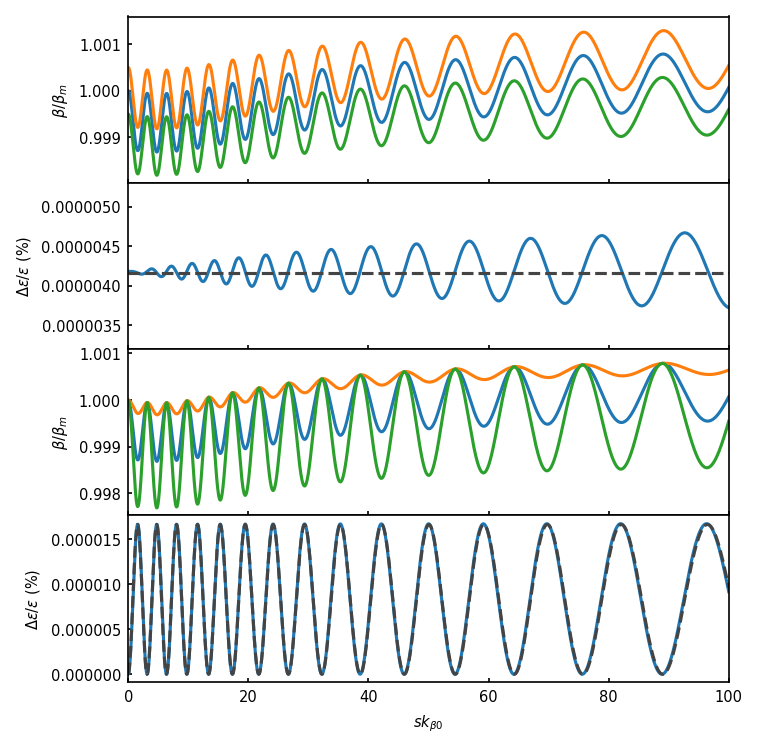

In [8]:
# Same as above but with very small energy spread to amplify dephasing
# Comparisons of beam evolution and emittance growth
# The complicated emittance growth and chromatic beam evolution plot
# Try setting a=0.2 and beta0=0.99 - oscillations of centroid energy go away
# Matches the prediction for the small correction to beta_m0 for being perfectly 
N = 50000
beta0 = 1.0
#beta0 = 1.0-.01
alpha0 = 0
gb0 = 20000
delta = 0.001
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.05
#a = .2
alpham = -a/2
z, dz = np.linspace(0, 1000, N, retstep=True)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*np.sqrt(1+deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
    
# Plotting
fig = plt.figure(figsize=(5, 5), dpi=150)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot([0, 100], [delta**2/24*100, delta**2/24*100], '--', c=grey)
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
#plt.ylim(-1e-4, 2.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))

# Plot 2 beams all start with the same initial conditions
#-----------------------------------------------------------------------------------------
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1-delta), dgdz0, ne0)

for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(1/betam)*dz

# Plotting
ax3 = plt.subplot(gs[2, 0], sharex=ax1)
ax3.plot(z, beta/betam)
ax3.plot(z, beta1/betam)
ax3.plot(z, betan1/betam)
plt.ylabel(r'$\beta/\beta_m$')
ax3.tick_params(top=False,bottom=True,left=True,direction='in',length=2)

ax4 = plt.subplot(gs[3, 0], sharex=ax1)
ax4.plot(z, (eps-1)*100)
ax4.plot(z, (1-np.cos(2*theta))*delta**2/12*100, '--', c=grey)
#plt.ylim(0, 1.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax4.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
plt.xlim(0, 100)
plt.xlabel(r'$s k_{\beta0}$')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

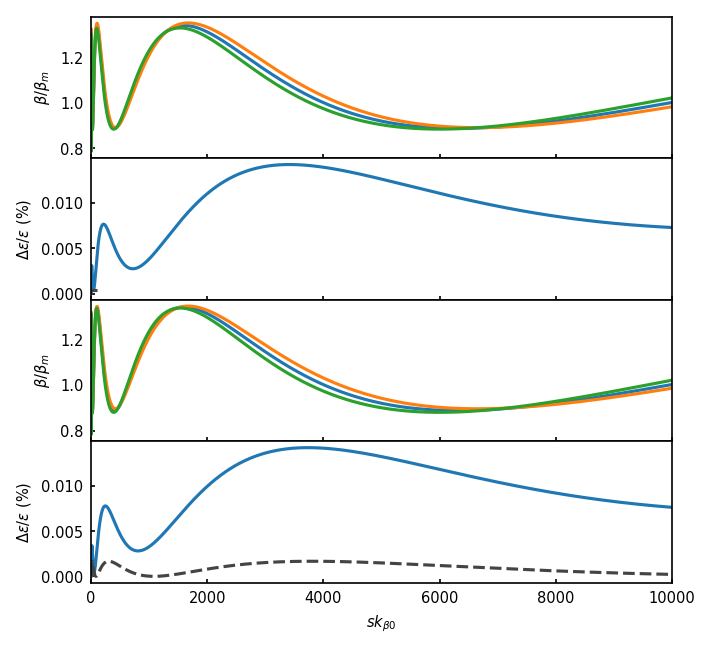

In [9]:
# Emittance growth due to the adibaticity of the ramp
N = 50000
beta0 = 1.0
alpha0 = 0
gb0 = 20000
delta = 0.01
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.8
#a = .2
alpham = -a/2
z, dz = np.linspace(0, 10000, N, retstep=True)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*np.sqrt(1+deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
    
# Plotting
fig = plt.figure(figsize=(5, 5), dpi=150)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot([0, 100], [delta**2/24*100, delta**2/24*100], '--', c=grey)
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
#plt.ylim(-1e-3, 2.5e-3)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))

# Plot 2 beams all start with the same initial conditions
#-----------------------------------------------------------------------------------------
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1-delta), dgdz0, ne0)

for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(1/betam)*dz

# Plotting
ax3 = plt.subplot(gs[2, 0], sharex=ax1)
ax3.plot(z, beta/betam)
ax3.plot(z, beta1/betam)
ax3.plot(z, betan1/betam)
plt.ylabel(r'$\beta/\beta_m$')
ax3.tick_params(top=False,bottom=True,left=True,direction='in',length=2)

ax4 = plt.subplot(gs[3, 0], sharex=ax1)
ax4.plot(z, (eps-1)*100)
ax4.plot(z, (1-np.cos(2*theta))*delta**2/12*100, '--', c=grey)
#plt.ylim(0, 1.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax4.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
plt.xlim(0, 10000)
plt.xlabel(r'$s k_{\beta0}$')

#plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

alpha_m= -0.5


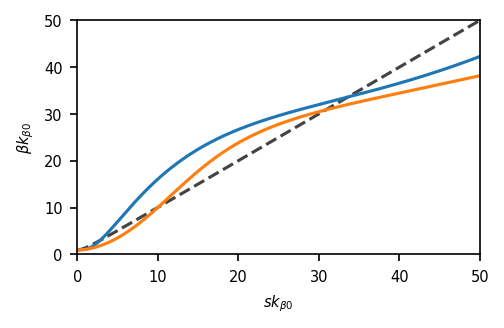

In [10]:
# Non adiabatic ramp figure - difficult to actually make non-adiabatic ramps
N = 10000
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 1.0
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(0, 100, N, retstep=True)
frac = 1/(1+(a*z)**2)
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Vacuum waist
betas = 1/np.array(gamma)

fig = plt.figure(figsize=(3.37, 2.2), dpi=150)
ax = plt.subplot(111)
#plt.plot(z, beta)
plt.plot(z, beta)
plt.plot(z, beta_adi, '--', c=grey, zorder=1)
plt.plot(z, betas)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
#plt.legend([r'Analytic', r'Adiabatic', r'$\beta_m$'], bbox_to_anchor=(.25, .75), loc='center')
#ax.yaxis.set_ticks(np.linspace(0, 12, 5))
plt.ylim(0, 50)
plt.xlim(0, 50)
plt.tight_layout()
plt.show()

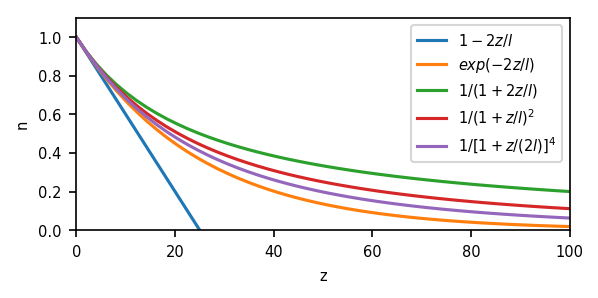

In [11]:
# Quick plot of the different ramp shapes from xu
z = np.linspace(0, 100)
l = 50
n1 = 1-2*z/l
n2 = np.exp(-2*z/l)
n3 = 1/(1+2*z/l)
n4 = 1/(1+z/l)**2
n5 = 1/(1+z/(2*l))**4

fig = plt.figure(figsize=(4, 2), dpi=150)
plt.plot(z, n1)
plt.plot(z, n2)
plt.plot(z, n3)
plt.plot(z, n4)
plt.plot(z, n5)
plt.legend([r'$1-2z/l$', r'$exp(-2z/l)$', r'$1/(1+2z/l)$', r'$1/(1+z/l)^2$', r'$1/[1+z/(2l)]^4$'])
plt.xlabel('z')
plt.ylabel('n')
plt.xlim(0, 100)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

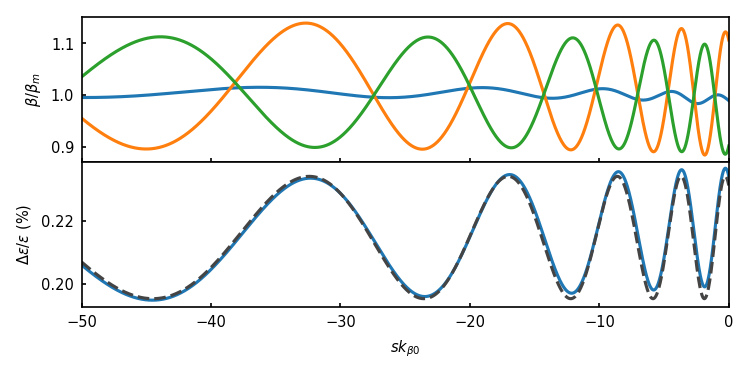

In [32]:
# Test linear beta and linear alpha into a adiabatic section
N = 10000
Zmin = -50
delta = 0.01
m = -4
p = 100
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
z, dz = np.linspace(Zmin, 0, N, retstep=True)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
betam = 1/np.sqrt(frac)
am = a/2
beta0 = betam[0]/np.sqrt(1+am**2)
alpha0 = am/np.sqrt(1+am**2)
# propagate the centroid energy and the extreme energy componenets
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*(1+m*delta), alpha0*(1+p*delta),
                                                  gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*(1-m*delta), alpha0*(1-p*delta),
                                                      gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*(1+m*deltaA[i]),
                                                                                  alpha0*(1+p*deltaA[i]), 
                                                                                  gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(1/betam)*dz
deltaPsi = theta*(1/np.sqrt(1+delta)-1/np.sqrt(1-delta))

# Analytic emittance calculation
a1 = (0.5 - 0.5*am**2-m-0.5*am**2*m)
a2 = am*(m-p)
a3 = 0.5*(1-am**2)-0.5*m*am**2
W2 = a1**2 + a2**2 + a3**2 + 2*a2*a3*np.sin(2*theta) - 2*a1*a3*np.cos(2*theta)

    
# Plotting
fig = plt.figure(figsize=(5, 2.5), dpi=150)
gs = gridspec.GridSpec(2, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam)
ax1.plot(z, beta1/betam)
ax1.plot(z, betan1/betam)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_m$')
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*100)
ax2.plot(z, 0.5*W2*delta**2*100/3, '--', c=grey)
#ax2.plot([0, z[-1]], [delta**2/24*100, delta**2/24*100], '--', c=grey)
#ax2.plot([0, z[-1]], [(epssat-1+delta**2/24)*100, (epssat-1+delta**2/24)*100], 'b--')
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
#plt.ylim(-0.005, 0.03)
#plt.text(0.5, 0.02, r'$\Delta\psi=$'+'%0.2f' % deltaPsi[-1])
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2E'))

plt.xlim(z[0], z[-1])
plt.xlabel(r'$s k_{\beta0}$')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()